In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance

PATH = Path('data')
list(PATH.iterdir())

[WindowsPath('data/houston_processed.feather'),
 WindowsPath('data/houston_processed_miles_time_diff.feather'),
 WindowsPath('data/houston_ready.feather'),
 WindowsPath('data/location_history.json')]

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_feather(PATH/'houston_processed.feather')

In [3]:
print(df.shape)
print(df.head(3).T)

(353793, 21)
   accuracy  altitude  heading  velocity  verticalAccuracy  act_conf1  \
0         8      30.0    161.0       0.0               NaN      100.0   
1         3      30.0    307.0       0.0               NaN        NaN   
2         6      31.0    320.0       0.0               NaN        NaN   
3         5      31.0    320.0       0.0               NaN      100.0   
4        12       NaN      NaN       NaN               NaN        NaN   

  act_type1  act_cont2 act_type2  extra_intVal    ...     extra_type  \
0     STILL        NaN      None           NaN    ...           None   
1      None        NaN      None           NaN    ...           None   
2      None        NaN      None           NaN    ...           None   
3   TILTING        NaN      None           NaN    ...           None   
4      None        NaN      None           NaN    ...           None   

                         date_time  year  month  day  day_of_week  hour  \
0 2013-12-08 14:58:27.870000-06:00  2013

In [4]:
df.dtypes

accuracy                                 int64
altitude                               float64
heading                                float64
velocity                               float64
verticalAccuracy                       float64
act_conf1                              float64
act_type1                               object
act_cont2                              float64
act_type2                               object
extra_intVal                           float64
extra_name                              object
extra_type                              object
date_time           datetime64[ns, US/Central]
year                                     int64
month                                    int64
day                                      int64
day_of_week                              int64
hour                                     int64
minute                                   int64
latitude                               float64
longitude                              float64
dtype: object

In [5]:
# # convert timestamp
# df['date_time'] = pd.to_datetime(df.timestampMs,unit='ms').dt.tz_localize('utc').dt.tz_convert('US/Central')

# df['year']=df.date_time.dt.year

# df['month']=df.date_time.dt.month

# df['day']=df.date_time.dt.day

# df['day_of_week']=df.date_time.dt.dayofweek

# df['hour']=df.date_time.dt.hour
# df['minute'] = df.date_time.dt.minute

# # convert lat - long
# df['latitude'] = df.latitudeE7 / 1e7
# df['longitude'] = df.longitudeE7 / 1e7

# df.drop(['latitudeE7','longitudeE7','timestampMs'],axis=1,inplace=True)

# df.to_feather(PATH/'houston_processed.feather')

In [5]:
# remove year 2013 due to lack of records
# idx_drop = df[df.year==2013].index

# df.drop(idx_drop,inplace=True)

# df.reset_index(drop=True,inplace=True)

In [8]:
df.groupby('year').count()

,accuracy,altitude,heading,velocity,verticalAccuracy,act_conf1,act_type1,act_cont2,act_type2,extra_intVal,extra_name,extra_type,date_time,month,day,day_of_week,hour,minute,latitude,longitude
year,,,,,,,,,,,,,,,,,,,,
2015,25114,7278,3822,483,0,17925,17925,10276,10276,0,0,0,25114,25114,25114,25114,25114,25114,25114,25114
2016,288622,148499,51228,4592,0,149389,149389,72541,72541,0,0,0,288622,288622,288622,288622,288622,288622,288622,288622
2017,29133,15132,4867,612,0,16005,16005,8050,8050,51,51,51,29133,29133,29133,29133,29133,29133,29133,29133


# Miles diff

In [9]:
# df_year = df[df.year==2015].copy()
# s=0
# e=len(df_year)-1

In [10]:
def calculate_distance(lat1,long1,lat2,long2):
    # geopy default distance calculation is geodesic distance
    return float("{0:.2f}".format(distance((lat1,long1),(lat2,long2)).miles))

In [11]:
lat2 = df.latitude.values
lat1 = df.latitude.shift().values
long2 = df.longitude.values
long1 = df.longitude.shift().values

In [12]:
# df_year['longitude_shift'] = df.longitude.shift()
# df_year['latitude_shift'] = df.latitude.shift()

# df_year.loc[0,'longitude_shift']=df_year.loc[0,'longitude']
# df_year.loc[0,'latitude_shift']=df_year.loc[0,'latitude']

# def miles_diff(row):
#     lat1,long1 = row['latitude_shift'],row['longitude_shift']
#     lat2,long2 = row['latitude'],row['longitude']
#     return calculate_distance(lat1,long1,lat2,long2)

In [27]:
# %%time
# temp=df_year.apply(miles_diff,axis=1)

CPU times: user 13 s, sys: 6.61 ms, total: 13 s
Wall time: 13 s


In [33]:
# quick test
# calculate_distance(*df_year.loc[10,['latitude','longitude','latitude_shift','longitude_shift']].values)

0.01

In [34]:
lat2 = df.latitude.values.tolist()
long2 = df.longitude.values.tolist()

lat1 = df.latitude.shift().values.tolist()
lat1[0] = lat2[0]
long1 = df.longitude.shift().values.tolist()
long1[0] = long2[0]

In [35]:
from concurrent.futures import ProcessPoolExecutor
def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, *args)
    return (list(res))

In [36]:
args = [lat1,long1,lat2,long2]

In [37]:
%%time
mile_diff = multiprocessing(calculate_distance,args,4)

CPU times: user 2min 7s, sys: 21.8 s, total: 2min 29s
Wall time: 2min 34s


In [38]:
df['mile_diff'] = mile_diff

In [40]:
df.to_feather(PATH/'houston_processed_miles_time_diff.feather')

In [ ]:
# # faster way to calculate miles diff: manually calculate haversine distance
# def haversine_array(lat1, lng1, lat2, lng2):
#     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
#     AVG_EARTH_RADIUS = 6371  # in km
#     lat = lat2 - lat1
#     lng = lng2 - lng1
#     d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
#     h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
#     return h

# lat2 = df.latitude.values.tolist()
# long2 = df.longitude.values.tolist()

# lat1 = df.latitude.shift().values.tolist()
# lat1[0] = lat2[0]
# long1 = df.longitude.shift().values.tolist()
# long1[0] = long2[0]

# mile_diff = haversine_array(lat1,long1,lat2,long2) 
# df['mile_diff'] = mile_diff * 0.621371 # to miles

In [25]:
df.mile_diff.describe()

count    342869.000000
mean          0.066116
std           4.244745
min           0.000000
25%           0.000000
50%           0.000000
75%           0.010000
max        1383.830000
Name: mile_diff, dtype: float64

In [113]:
df[df.mile_diff>15].date_time.T
# all of these are out-of-state plane travel or out of city travel

101995   2016-04-18 16:09:29.947000-05:00
102006   2016-04-18 16:42:19.529000-05:00
131455   2016-05-31 08:45:07.737000-05:00
131476   2016-05-31 09:52:01.391000-05:00
131481   2016-05-31 09:55:55.303000-05:00
131482   2016-05-31 09:57:36.771000-05:00
131495   2016-05-31 10:01:51.323000-05:00
131496   2016-05-31 10:03:51.072000-05:00
131497   2016-05-31 10:36:19.283000-05:00
131519   2016-05-31 11:37:15.067000-05:00
134675   2016-06-03 18:54:32.708000-05:00
134693   2016-06-03 22:23:47.573000-05:00
235923   2016-10-13 08:06:06.859000-05:00
235927   2016-10-13 08:09:45.858000-05:00
235947   2016-10-13 08:26:15.886000-05:00
235957   2016-10-13 08:31:45.522000-05:00
235971   2016-10-13 08:37:53.853000-05:00
235975   2016-10-13 08:44:27.450000-05:00
235991   2016-10-13 10:14:22.011000-05:00
236517   2016-10-13 20:20:59.379000-05:00
301799   2016-12-21 14:37:12.931000-06:00
301800   2016-12-21 14:38:26.392000-06:00
301801   2016-12-21 14:41:14.081000-06:00
301802   2016-12-21 14:45:24.94000

High mile diff:
- GPS glitch?
- On plane: when on a plane (airplane mode, no gps recorded), every 100-200 seconds it will use the last gps recorded. When airplane mode is off, it will record new gps which results in a huge difference

# time diff (in second)

In [52]:
date_shift = df.date_time.shift()
date_shift.loc[0] = df.date_time.loc[0]

In [57]:
df['sec_diff']=(df.date_time - date_shift).astype('timedelta64[s]')

In [58]:
df.to_feather(PATH/'houston_processed_miles_time_diff.feather')

In [ ]:
# df = pd.read_feather(PATH/'houston_processed_miles_time_diff.feather')

In [3]:
df.sec_diff.describe()

count    342869.000000
mean        107.038435
std         229.959529
min           0.000000
25%          21.000000
50%          60.000000
75%         123.000000
max       46221.000000
Name: sec_diff, dtype: float64

In [98]:
df[df.sec_diff>1000].shape
# few reasons for high time diff (> 5 hours): phone died, phone inactive at night (rare)

(658, 23)

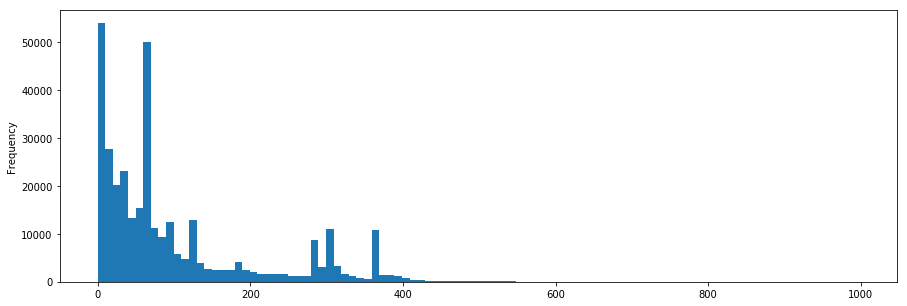

In [101]:
df[df.sec_diff<1000].sec_diff.plot(kind='hist',bins=100,figsize=(15,5))
#majority of sec diff is < 200

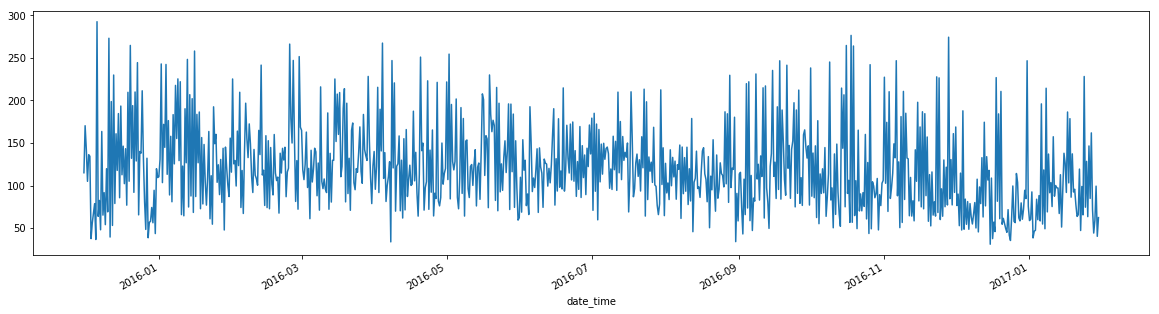

In [4]:
df[df.sec_diff<1000].set_index('date_time').sec_diff.resample('12H').mean().plot(figsize=(20,5))

In [6]:
df_month = df[(df.year==2016) & (df.month==9)]

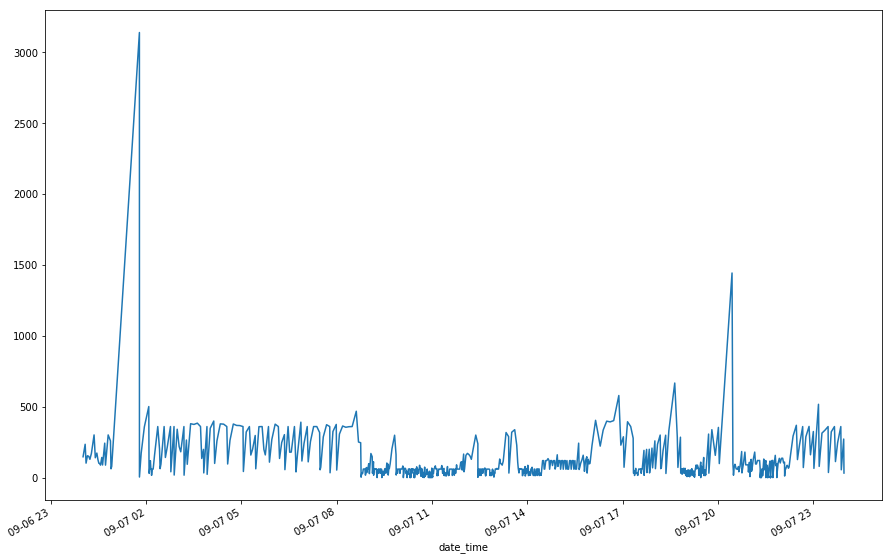

In [22]:
df_month[(df_month.sec_diff<6000) & (df_month.day==7)].set_index('date_time').sec_diff.plot(figsize=(15,10))

For a typical work day, time diff is bigger during sleep time (before 9 am), smaller (more condense) during work time, and a mix between big and small during night time?

# identify abnormal speed

In [2]:
df = pd.read_feather(PATH/'houston_processed_miles_time_diff.feather')
df.shape

(342869, 23)

In [3]:
# max speed: 90 mph, convert to mps
max_mps=90/3600 

In [4]:
df_timediff = df[df.sec_diff!=0]
df_abnormal=df_timediff[df_timediff.mile_diff / df_timediff.sec_diff >= max_mps]

In [5]:
df_abnormal.shape

(3359, 23)

In [7]:
print(df_abnormal[(df_abnormal.mile_diff>1) & (df_abnormal.mile_diff<15 )].shape)
# keeping small glitches (<1 miles) and plane travel (probably > 15 miles)
abnormal_idx = df_abnormal[(df_abnormal.mile_diff>1) & (df_abnormal.mile_diff<15 )].index

(1116, 23)


In [8]:
df.drop(abnormal_idx,inplace=True)

In [9]:
# at this point, mile diff and sec diff have to be recalculated. Remove them for now
df.drop(['mile_diff','sec_diff'],axis=1,inplace=True)

In [10]:
df.reset_index(drop=True,inplace=True)

In [12]:
df.tail().T

,341748,341749,341750,341751,341752
accuracy,8,8,8,585,545
altitude,4,4,4,19,23
heading,224,224,224,NaN,NaN
velocity,NaN,NaN,NaN,NaN,NaN
verticalAccuracy,NaN,NaN,NaN,NaN,NaN
act_conf1,NaN,100,100,100,100
act_type1,None,STILL,STILL,STILL,STILL
act_cont2,NaN,NaN,NaN,NaN,NaN
act_type2,None,None,None,None,None
extra_intVal,NaN,NaN,NaN,NaN,NaN


In [13]:
df.to_feather(PATH/'houston_ready.feather')

# Geographics

In [3]:
df = pd.read_feather(PATH/'houston_ready.feather')

In [4]:
df.shape

(341753, 21)

In [19]:
lat_border = (df.latitude.min()-0.1,df.latitude.max()+0.1)
lat_border

(24.450768, 40.8970216)

In [16]:
df.longitude.describe()

count    341753.000000
mean        -94.761312
std           3.217088
min         -98.492093
25%         -95.343424
50%         -95.271291
75%         -95.271204
max         -73.863607
Name: longitude, dtype: float64

In [20]:
long_border = (df.longitude.min()-0.1,df.longitude.max()+0.1)
long_border

(-98.5920927, -73.7636073)

(-98.5920927, -73.7636073)

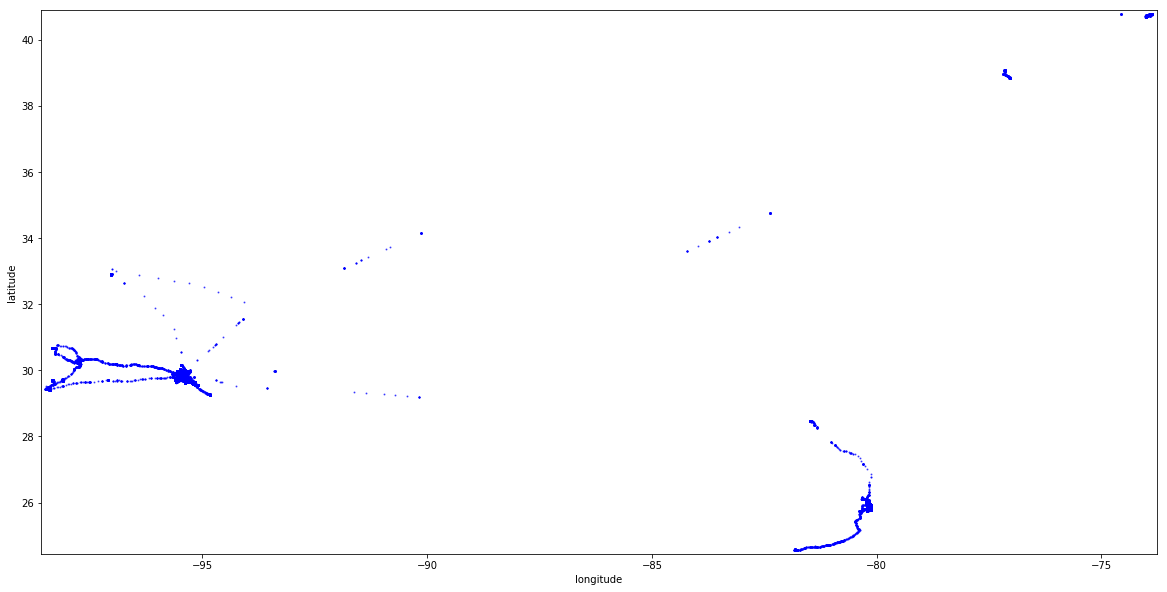

In [32]:
fig,ax = plt.subplots(figsize=(20,10))
ax.scatter(df.longitude,df.latitude,color='blue',s=1,alpha=0.6)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(lat_border)
plt.xlim(long_border)

Text(0.5,0,'longitude')

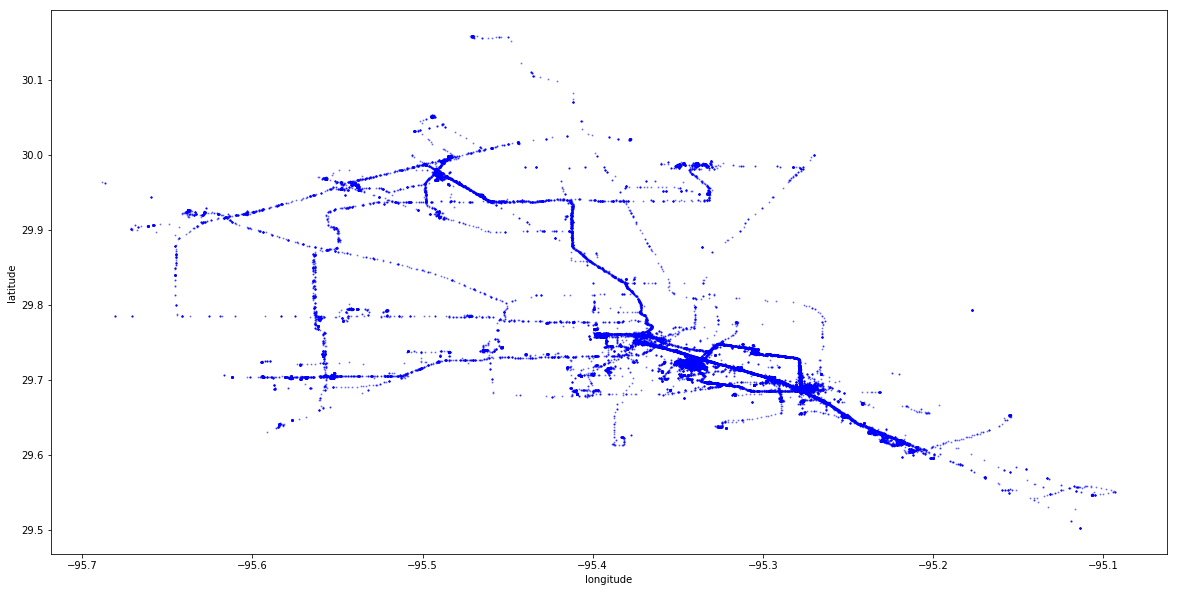

In [36]:
# analyzing Houston area
df_houston = df[(df.longitude <=-95) & (df.longitude >=-95.7)& (df.latitude >= 29.5) & (df.latitude <= 30.25)]

fig,ax = plt.subplots(figsize=(20,10))
ax.scatter(df_houston.longitude,df_houston.latitude,color='blue',s=1,alpha=0.4)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

Look pretty good. Houston city map is recognizable, and you can also see some travelling (car and plane).

Scatter plots of GPS points, which reviews road network of Houston. You can also see some dense path and dense areas (more travelled)

# Single feature EDA

In [73]:
df = pd.read_feather(PATH/'houston_ready.feather')
df.shape

(341753, 21)

In [5]:
# % of missing values for each features
(df.isnull().sum() / len(df)) * 100

accuracy              0.000000
altitude             50.257935
heading              82.712954
velocity             98.336811
verticalAccuracy    100.000000
act_conf1            46.608808
act_type1            46.608808
act_cont2            73.497233
act_type2            73.497233
extra_intVal         99.985077
extra_name           99.985077
extra_type           99.985077
date_time             0.000000
year                  0.000000
month                 0.000000
day                   0.000000
day_of_week           0.000000
hour                  0.000000
minute                0.000000
latitude              0.000000
longitude             0.000000
dtype: float64

## altitude

In [6]:
df.altitude.describe()

count    169995.000000
mean         -0.559893
std         321.730200
min       -9283.000000
25%         -24.000000
50%         -14.000000
75%           1.000000
max       11797.000000
Name: altitude, dtype: float64

In [7]:
df[df.altitude >= 2000].groupby(['year','month','day']).accuracy.count()
# altitude can glitch as well. Some locations with high altitude are actually near home

year  month  day
2016  5      31     63
      6      3      18
      8      16      3
      9      3       2
             6       6
      10     13     64
      11     19      1
      12     21     24
             29     23
Name: accuracy, dtype: int64

Altitude can glitch as well. Some locations with high altitude are actually near home

In [13]:
df[df.altitude >= 5000].groupby(['year','month','day']).accuracy.count()
# about 5000 feet it seems to get all the airplane GPS point

year  month  day
2016  5      31     63
      6      3      18
      10     13     62
      12     21     16
             29     16
Name: accuracy, dtype: int64

In [23]:
# def get_exact(df,year,month,day):
#     return df[(df.year == year) & (df.month == month) & (df.day==day)]
# get_exact(df[df.altitude < -400],2016,11,20)

In [62]:
lowest=-400
df[df.altitude < lowest].groupby(['year','month','day']).accuracy.count()
df[df.altitude < lowest].shape

year  month  day
2016  1      15      1
             28      6
      2      5       4
             9       1
             20      1
             24      1
      3      4       1
             14      1
             20      2
      4      2       1
             19      1
             28      2
      6      1       2
             28      1
      7      17      5
             27      2
      8      1       1
             3       1
             6       4
             16     30
             17      4
             18      5
             25     12
             26      9
             28      4
      9      2      36
             3      87
             4      81
             5      90
             6      79
             30      3
      10     4      24
             5      63
             6      53
             7       1
             12      4
             27      1
      11     9       1
             19     19
             20     53
             28      2
             29      1
      12     1   

(708, 21)

Using Google Timeline site, majority of these 'low' altitudes are glitch. Majority of them are at home

In [74]:
# remove low altitude. Keep high altitude as it can be plane travel
df[(df.altitude >=-400) | (df.altitude.isnull())].shape
df.shape

(341045, 21)

(341753, 21)

In [75]:
df = df[(df.altitude >=-400) | (df.altitude.isnull())]

In [76]:
df.shape

(341045, 21)

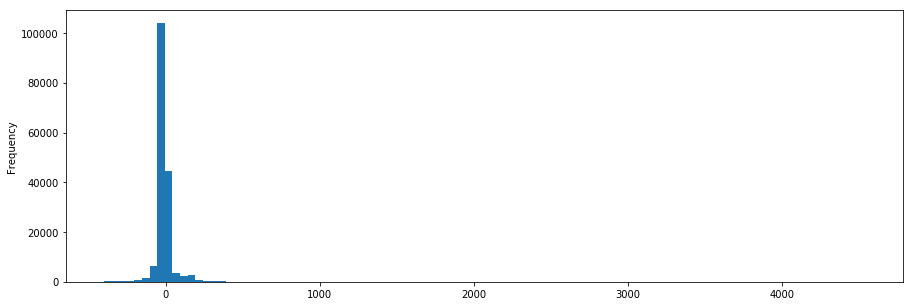

In [78]:
# view ground (normal) altitude
df[df.altitude < 5000].altitude.plot(kind='hist',bins=100,figsize=(15,5))

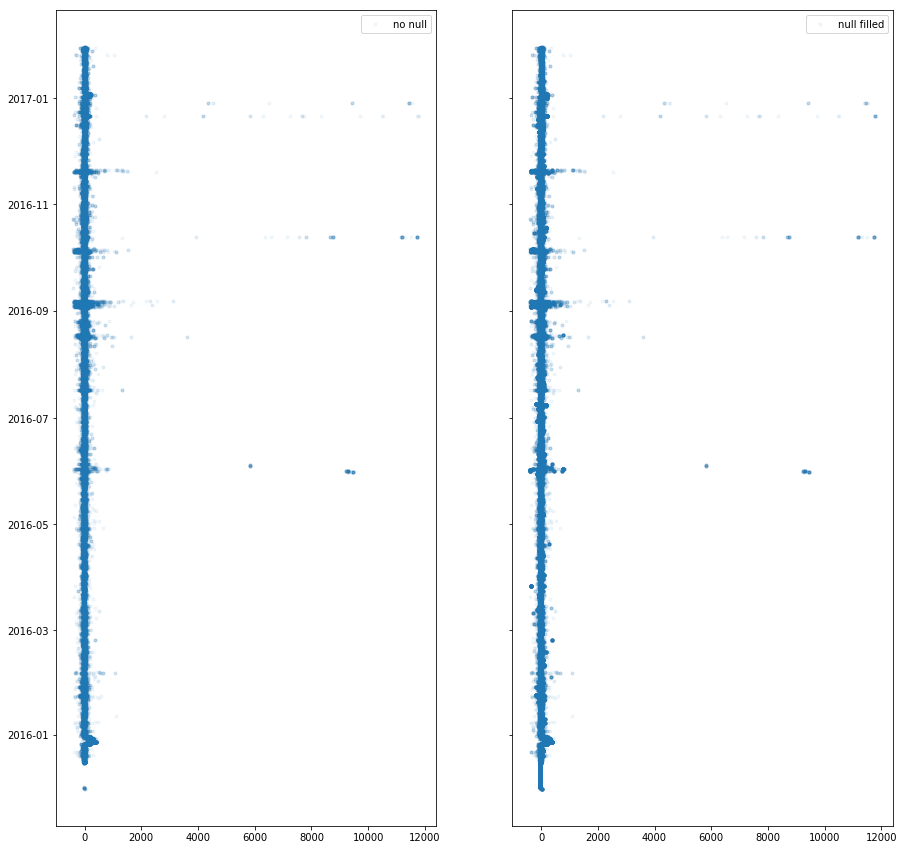

In [100]:
# Altitude cannot be changed easily, so use forward fill
alt = df.altitude
alt_fillna = df.altitude.fillna(method='ffill')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,15),sharex=True,sharey=True)
ax[0].plot(alt,df.date_time,'.',alpha=0.05,label='no null')
ax[1].plot(alt_fillna,df.date_time,'.',alpha=0.05,label='null filled')

ax[0].legend(loc=0)
ax[1].legend(loc=0)

In the left graph (null data isn't plotted), there aren't many gaps even altitude contains 50% missing values. Forward filling is not a bad first choice

In [ ]:
# df.altitude.fillna(method='ffill',inplace=True)

## heading

In [79]:
df.heading.describe()
# 0-360 degree?

count    58748.000000
mean       186.498025
std        101.580146
min          0.000000
25%        106.000000
50%        180.000000
75%        277.000000
max        359.000000
Name: heading, dtype: float64

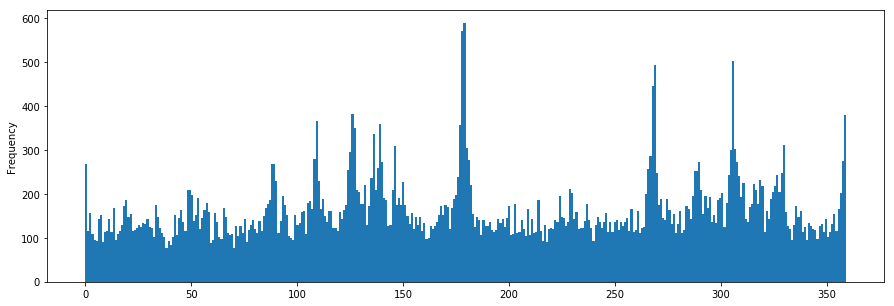

In [108]:
df.heading.plot(kind='hist',bins=360,figsize=(15,5))

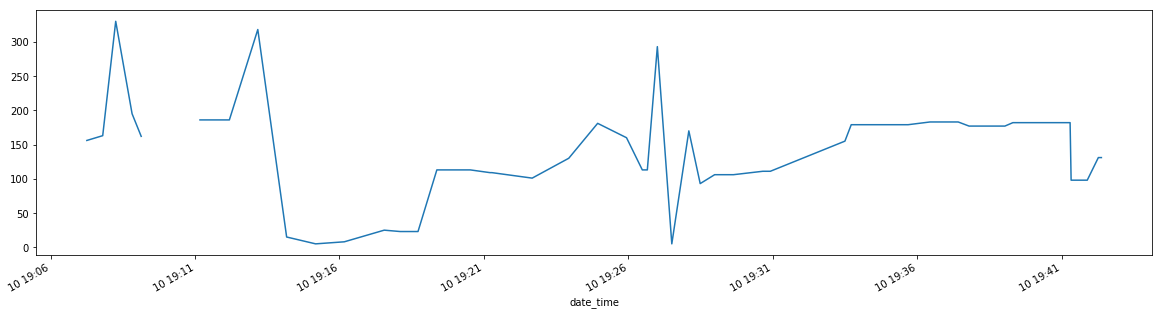

In [137]:
df[(df.year==2016) & (df.month==10)  & (df.day==10) & (df.hour >= 19) & (df.hour <21)].set_index('date_time').heading.plot(figsize=(20,5))
# Taking the bus home on a typical home-school-home day

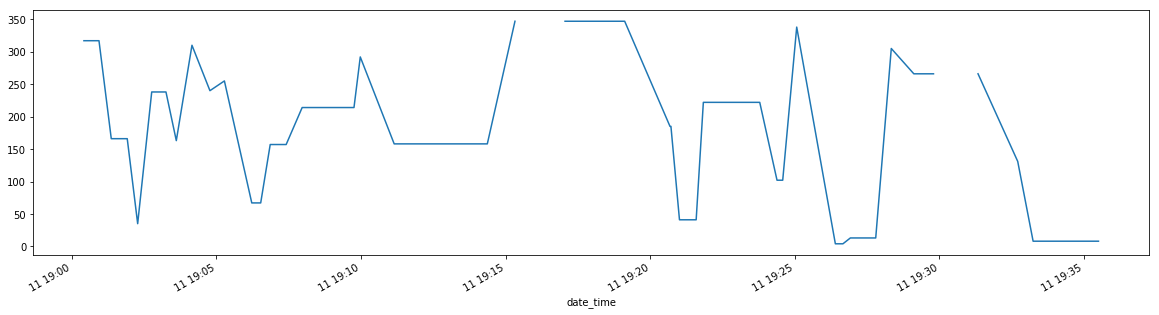

In [138]:
df[(df.year==2016) & (df.month==10)  & (df.day==11) & (df.hour >= 19) & (df.hour <21)].set_index('date_time').heading.plot(figsize=(20,5))
# same routine, a date later home-school-eat-school-home

Unfortunately, not the same pattern

In [164]:
df_temp = df[~df.heading.isnull()]
df_temp.act_type1.value_counts() / len(df_temp)
# a record with heading has higher chance to have type 'IN_VEHICLE' or 'TILTING'

IN_VEHICLE         0.285865
TILTING            0.284605
STILL              0.092088
UNKNOWN            0.044444
ON_FOOT            0.012579
EXITING_VEHICLE    0.010996
ON_BICYCLE         0.002826
Name: act_type1, dtype: float64

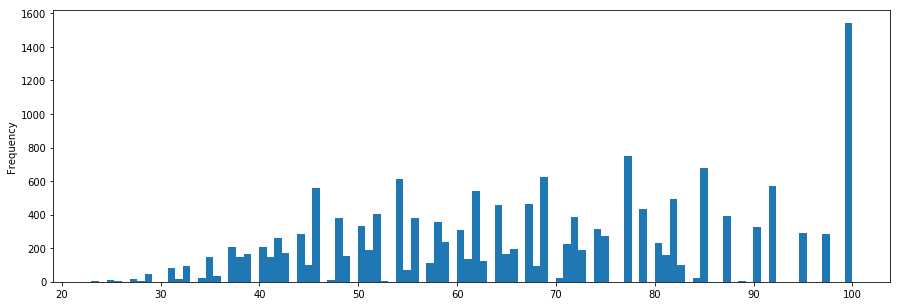

In [165]:
df_temp[df_temp.act_type1=='IN_VEHICLE'].act_conf1.plot(kind='hist',bins=100,figsize=(15,5))

In [166]:
len(df_temp[(df_temp.act_type1=='IN_VEHICLE') & (df_temp.act_conf1 >=80)]) / len(df_temp[df_temp.act_type1=='IN_VEHICLE'])

0.30350125044658804

For records with heading, only ~30% of them have IN_VEHICLE confidence >=80, meaning having heading does not always mean user is in a vehicle

Heading would be a bad feature to be considered because:
- 82% missing values
- Not stable (different pattern for 2 similar records)
- Not sure how heading is generated. My best bet: heading is related to vehicle heading, but only 30% of records with heading have high IN_VEHICLE confidence

We can extract these records with heading to study them later.

## Velocity

98% missing values

In [173]:
df.velocity.describe()

count    5677.000000
mean        2.370442
std         5.877268
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        34.000000
Name: velocity, dtype: float64

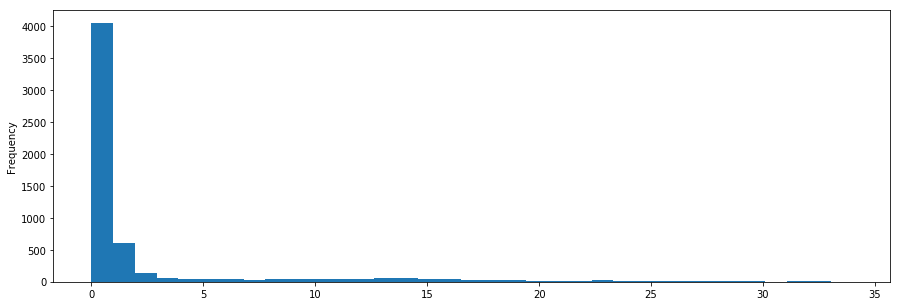

In [44]:
df.velocity.plot(kind='hist',bins=35,figsize=(15,5))

Not sure if this is mph or kph. TODO: what kind of data has non-null velocity?

## Activity type and activity confidence

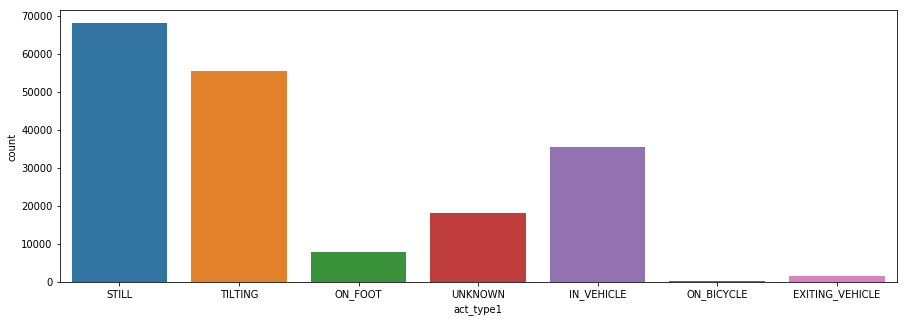

In [51]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(ax=ax,x=df.act_type1,data=df)

In [20]:
df.extra_type.value_counts()

VALUE    51
Name: extra_type, dtype: int64

# TODO: clustering and plotting cluster

# TODO: identify weekday and weekend point

# TODO: identify 'home' and 'work' cluster

# TODO: identify 'vacation' and other clusters